# Load Tools

In [1]:
# tools
import numpy as np
import numpy.random as rand
import collections
from scipy.interpolate import Rbf
from sklearn.manifold import TSNE
import numba as nb

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Load Simulated Data

In [2]:
# output the value
file_name = "data_simulation.npz"

# open the file for reading
file_object = open(file_name, 'rb') # wb --- write binary

# read data
data         = np.load(file_object)
label_groups = data['label_groups']
num_cells    = data['num_cells']
samples      = data['samples']

# close the file
file_object.close()

In [3]:
# get the parameters
tmp = collections.Counter(label_groups)
num_groups  = len(tmp)
num_samples = list(tmp.values())

num_samples_tot, num_cells_tot, num_features = samples.shape
num_celltypes = num_cells.shape[1]

print("# of groups:                    ", num_groups)
print("# of samples in total:          ", num_samples_tot)
print("# of samples for each group:    ", num_samples)
print("# of cells for each sample:     ", num_cells_tot)
print("# of cell types for each sample:", num_celltypes)
print("# of genes / markers / features:", num_features)

# of groups:                     2
# of samples in total:           100
# of samples for each group:     [70, 30]
# of cells for each sample:      100000
# of cell types for each sample: 2
# of genes / markers / features: 3


In [4]:
def data_standardization(samples, verbose = True):
    """standardized features of all samples"""
    
    if (verbose):
        print("Data Standardization...")
        
    # initialization
    # assert(len(samples.shape) == 3)
    num_samples_tot, num_cells_tot, num_features = samples.shape
    
    ##### standardization #####
    # standardize
    res = np.vstack(samples)
    res = (res - np.mean(res, axis=0)) / np.std(res, axis=0)

    # reshape the matrix back
    res = np.expand_dims(res, axis = 0)
    res = res.reshape(num_samples_tot, num_cells_tot, num_features)
    
    if (verbose):
        print("...Finish")
    return(res)

In [5]:
def data_augmentation(samples, label_groups, k = 1000, num_subsets = 10, rand_seed = 0, verbose = True):
    """create t-SNE plot for each sample"""
    
    if (verbose):
        print("Data Augmentation...")
    # initialization
    # assert(len(samples.shape) == 3)
    rand.seed(rand_seed)
    num_samples_tot, num_cells_tot, num_features = samples.shape
    result_samples = []
    result_labels  = []
    
    # iterate through all samples
    for idx_sample in range(num_samples_tot):
        sample = samples[idx_sample]
        
        # record the corresponding label
        group  = label_groups[idx_sample]
        result_labels += ([group] * num_subsets)
        
        # generate subsets in each sample
        for _ in range(num_subsets):
            
            # choose k cells randomly
            idx = rand.permutation(num_cells_tot)[:k]
            result_samples.append(samples[idx_sample][idx])
              
    # arrange result
    result_samples = np.array(result_samples) # (num_samples_tot * num_subsets, k, num_genes)
    result_labels  = np.array(result_labels)  # (num_samples_tot * num_subsets,)
    
    if (verbose):
        print("...Finish")
    
    return result_labels, result_samples

In [6]:
def create_tsne(samples, rand_seed = 0, verbose = True):
    """create t-SNE plot for each sample"""
    
    if (verbose):
        print("Create t-SNE plots...")
    
    # initialization
    # assert(len(samples.shape) == 3)
    rand.seed(rand_seed)
    num_samples_tot, num_cells_tot, num_features = samples.shape
    result_tsne = []
    
    # generate tsne plot for each sample
    for idx_sample in range(num_samples_tot):
        if (verbose):
            print("    Prepare t-SNE plot of the", idx_sample, "sample")
        
        # for each sample, generate a t-SNE plot
        sample = samples[idx_sample]
        tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300) # To-Do: set the random state
        res = tsne.fit_transform(sample)
        result_tsne.append(res)
    
    # convert the result from list to numpy array
    result_tsne = np.array(result_tsne)
    
    if (verbose):
        print("...Finish")
        
    return result_tsne

In [7]:
def create_img(tsne_plots, samples, n_grid = 128, verbose = True):
    """create image from t-SNE plot"""
    
    if (verbose):
        print("Create images from t-SNE plot...")
        
    # initialization
    # assert tsne_plots.shape[0] == tsne_plots.shape[0]
    num_samples_tot, num_cells_tot, num_features = samples.shape
    result_img = []
    
    # iterate though each samples
    for idx_sample in range(num_samples_tot):
        if (verbose):
            print("    Prepare image of the", idx_sample, "sample")
        
        # get each sample and its corresponding plot
        sample = samples[idx_sample]
        tsne_plot = tsne_plots[idx_sample]
        
        # get x, y coordinate of a plot
        x = tsne_plot[:, 0]
        y = tsne_plot[:, 1]
        
        # generate a grid
        x_c = np.linspace(min(x), max(x), n_grid)
        y_c = np.linspace(min(y), max(y), n_grid)
        x_c, y_c = np.meshgrid(x_c, y_c)
        
        # each feature is a layer/channel for the plot
        # to get each layer, perform interpolation to convert tSNE plot in a image
        result_z = []
        for idx_feature in range(num_features):
        
            z = sample[:, idx_feature]
            rbfi = Rbf(x, y, z, function='multiquadric', smooth=1)
            z_c = rbfi(x_c, y_c)
            result_z.append(z_c)
            #print(z_c.shape)
            
        # arrange the interpolated feature values    
        #print(len(result_z))
        result_z = np.array(result_z)
        
        # append each interpolated result to the result
        result_img.append(result_z)
        #print(len(result_img))
    
    # convert the result from list to numpy array
    result_img = np.array(result_img)
    
    if (verbose):
        print("...Finish")
        
    return result_img

# Check functions

In [8]:
tmp = samples
tmp = data_standardization(tmp)

data_labels, data_samples = data_augmentation(tmp, label_groups, k = 9, num_subsets = 8)

tmp = data_samples[0:6]
data_tsne = create_tsne(tmp)
data_img = create_img(data_tsne, tmp)

print("================")
print("check dimension")
print(data_samples.shape)
print(data_labels.shape)
print(data_tsne.shape)
print(data_img.shape)

print("================")
print(data_samples[0][0])
print(data_tsne[0][0])
print(data_img[0][0])
print("================")
print(data_samples[1][0])
print(data_tsne[1][0])
print(data_img[1][0])

Data Standardization...
...Finish
Data Augmentation...
...Finish
Create t-SNE plots...
    Prepare t-SNE plot of the 0 sample
    Prepare t-SNE plot of the 1 sample
    Prepare t-SNE plot of the 2 sample
    Prepare t-SNE plot of the 3 sample
    Prepare t-SNE plot of the 4 sample
    Prepare t-SNE plot of the 5 sample
...Finish
Create images from t-SNE plot...
    Prepare image of the 0 sample
    Prepare image of the 1 sample
    Prepare image of the 2 sample
    Prepare image of the 3 sample
    Prepare image of the 4 sample
    Prepare image of the 5 sample
...Finish
check dimension
(800, 9, 3)
(800,)
(6, 9, 2)
(6, 3, 128, 128)
[-0.40304374 -0.82390292 -0.83977724]
[ -49.935776 -132.97229 ]
[[-0.57919377 -0.57650995 -0.57383502 ... -0.52629322 -0.52763047
  -0.52897488]
 [-0.57813541 -0.57544896 -0.57277109 ... -0.52479121 -0.52612114
  -0.52745808]
 [-0.57710908 -0.57442049 -0.57174018 ... -0.52331473 -0.52463678
  -0.52596567]
 ...
 [-0.45087188 -0.44849912 -0.4461569  ... -0.332

# Run and Store the results

In [9]:
tmp = samples
tmp = data_standardization(tmp)

data_labels, data_samples = data_augmentation(tmp, label_groups, k = 1000, num_subsets = 10)

tmp = data_samples
data_tsne = create_tsne(tmp)

########################################
# output the value
file_name = "data_tsne.npz"

# open the file for writing
file_object = open(file_name, 'wb') # wb --- write binary

# write data to the file
np.savez(
    file_object, 
    data_samples = data_samples, 
    data_labels  = data_labels, 
    data_tsne    = data_tsne)

# close the file
file_object.close()

print("The tsne results are stored.")

Data Standardization...
...Finish
Data Augmentation...
...Finish
Create t-SNE plots...
    Prepare t-SNE plot of the 0 sample
    Prepare t-SNE plot of the 1 sample
    Prepare t-SNE plot of the 2 sample
    Prepare t-SNE plot of the 3 sample
    Prepare t-SNE plot of the 4 sample
    Prepare t-SNE plot of the 5 sample
    Prepare t-SNE plot of the 6 sample
    Prepare t-SNE plot of the 7 sample
    Prepare t-SNE plot of the 8 sample
    Prepare t-SNE plot of the 9 sample
    Prepare t-SNE plot of the 10 sample
    Prepare t-SNE plot of the 11 sample
    Prepare t-SNE plot of the 12 sample
    Prepare t-SNE plot of the 13 sample
    Prepare t-SNE plot of the 14 sample
    Prepare t-SNE plot of the 15 sample
    Prepare t-SNE plot of the 16 sample
    Prepare t-SNE plot of the 17 sample
    Prepare t-SNE plot of the 18 sample
    Prepare t-SNE plot of the 19 sample
    Prepare t-SNE plot of the 20 sample
    Prepare t-SNE plot of the 21 sample
    Prepare t-SNE plot of the 22 sample
   

    Prepare t-SNE plot of the 201 sample
    Prepare t-SNE plot of the 202 sample
    Prepare t-SNE plot of the 203 sample
    Prepare t-SNE plot of the 204 sample
    Prepare t-SNE plot of the 205 sample
    Prepare t-SNE plot of the 206 sample
    Prepare t-SNE plot of the 207 sample
    Prepare t-SNE plot of the 208 sample
    Prepare t-SNE plot of the 209 sample
    Prepare t-SNE plot of the 210 sample
    Prepare t-SNE plot of the 211 sample
    Prepare t-SNE plot of the 212 sample
    Prepare t-SNE plot of the 213 sample
    Prepare t-SNE plot of the 214 sample
    Prepare t-SNE plot of the 215 sample
    Prepare t-SNE plot of the 216 sample
    Prepare t-SNE plot of the 217 sample
    Prepare t-SNE plot of the 218 sample
    Prepare t-SNE plot of the 219 sample
    Prepare t-SNE plot of the 220 sample
    Prepare t-SNE plot of the 221 sample
    Prepare t-SNE plot of the 222 sample
    Prepare t-SNE plot of the 223 sample
    Prepare t-SNE plot of the 224 sample
    Prepare t-SN

    Prepare t-SNE plot of the 401 sample
    Prepare t-SNE plot of the 402 sample
    Prepare t-SNE plot of the 403 sample
    Prepare t-SNE plot of the 404 sample
    Prepare t-SNE plot of the 405 sample
    Prepare t-SNE plot of the 406 sample
    Prepare t-SNE plot of the 407 sample
    Prepare t-SNE plot of the 408 sample
    Prepare t-SNE plot of the 409 sample
    Prepare t-SNE plot of the 410 sample
    Prepare t-SNE plot of the 411 sample
    Prepare t-SNE plot of the 412 sample
    Prepare t-SNE plot of the 413 sample
    Prepare t-SNE plot of the 414 sample
    Prepare t-SNE plot of the 415 sample
    Prepare t-SNE plot of the 416 sample
    Prepare t-SNE plot of the 417 sample
    Prepare t-SNE plot of the 418 sample
    Prepare t-SNE plot of the 419 sample
    Prepare t-SNE plot of the 420 sample
    Prepare t-SNE plot of the 421 sample
    Prepare t-SNE plot of the 422 sample
    Prepare t-SNE plot of the 423 sample
    Prepare t-SNE plot of the 424 sample
    Prepare t-SN

    Prepare t-SNE plot of the 601 sample
    Prepare t-SNE plot of the 602 sample
    Prepare t-SNE plot of the 603 sample
    Prepare t-SNE plot of the 604 sample
    Prepare t-SNE plot of the 605 sample
    Prepare t-SNE plot of the 606 sample
    Prepare t-SNE plot of the 607 sample
    Prepare t-SNE plot of the 608 sample
    Prepare t-SNE plot of the 609 sample
    Prepare t-SNE plot of the 610 sample
    Prepare t-SNE plot of the 611 sample
    Prepare t-SNE plot of the 612 sample
    Prepare t-SNE plot of the 613 sample
    Prepare t-SNE plot of the 614 sample
    Prepare t-SNE plot of the 615 sample
    Prepare t-SNE plot of the 616 sample
    Prepare t-SNE plot of the 617 sample
    Prepare t-SNE plot of the 618 sample
    Prepare t-SNE plot of the 619 sample
    Prepare t-SNE plot of the 620 sample
    Prepare t-SNE plot of the 621 sample
    Prepare t-SNE plot of the 622 sample
    Prepare t-SNE plot of the 623 sample
    Prepare t-SNE plot of the 624 sample
    Prepare t-SN

    Prepare t-SNE plot of the 801 sample
    Prepare t-SNE plot of the 802 sample
    Prepare t-SNE plot of the 803 sample
    Prepare t-SNE plot of the 804 sample
    Prepare t-SNE plot of the 805 sample
    Prepare t-SNE plot of the 806 sample
    Prepare t-SNE plot of the 807 sample
    Prepare t-SNE plot of the 808 sample
    Prepare t-SNE plot of the 809 sample
    Prepare t-SNE plot of the 810 sample
    Prepare t-SNE plot of the 811 sample
    Prepare t-SNE plot of the 812 sample
    Prepare t-SNE plot of the 813 sample
    Prepare t-SNE plot of the 814 sample
    Prepare t-SNE plot of the 815 sample
    Prepare t-SNE plot of the 816 sample
    Prepare t-SNE plot of the 817 sample
    Prepare t-SNE plot of the 818 sample
    Prepare t-SNE plot of the 819 sample
    Prepare t-SNE plot of the 820 sample
    Prepare t-SNE plot of the 821 sample
    Prepare t-SNE plot of the 822 sample
    Prepare t-SNE plot of the 823 sample
    Prepare t-SNE plot of the 824 sample
    Prepare t-SN

Note: once the create image stucked at sample index 274

In [10]:
data_img = create_img(data_tsne, tmp)

Create images from t-SNE plot...
    Prepare image of the 0 sample
    Prepare image of the 1 sample
    Prepare image of the 2 sample
    Prepare image of the 3 sample
    Prepare image of the 4 sample
    Prepare image of the 5 sample
    Prepare image of the 6 sample
    Prepare image of the 7 sample
    Prepare image of the 8 sample
    Prepare image of the 9 sample
    Prepare image of the 10 sample
    Prepare image of the 11 sample
    Prepare image of the 12 sample
    Prepare image of the 13 sample
    Prepare image of the 14 sample
    Prepare image of the 15 sample
    Prepare image of the 16 sample
    Prepare image of the 17 sample
    Prepare image of the 18 sample
    Prepare image of the 19 sample
    Prepare image of the 20 sample
    Prepare image of the 21 sample
    Prepare image of the 22 sample
    Prepare image of the 23 sample
    Prepare image of the 24 sample
    Prepare image of the 25 sample
    Prepare image of the 26 sample
    Prepare image of the 27 samp

    Prepare image of the 230 sample
    Prepare image of the 231 sample
    Prepare image of the 232 sample
    Prepare image of the 233 sample
    Prepare image of the 234 sample
    Prepare image of the 235 sample
    Prepare image of the 236 sample
    Prepare image of the 237 sample
    Prepare image of the 238 sample
    Prepare image of the 239 sample
    Prepare image of the 240 sample
    Prepare image of the 241 sample
    Prepare image of the 242 sample
    Prepare image of the 243 sample
    Prepare image of the 244 sample
    Prepare image of the 245 sample
    Prepare image of the 246 sample
    Prepare image of the 247 sample
    Prepare image of the 248 sample
    Prepare image of the 249 sample
    Prepare image of the 250 sample
    Prepare image of the 251 sample
    Prepare image of the 252 sample
    Prepare image of the 253 sample
    Prepare image of the 254 sample
    Prepare image of the 255 sample
    Prepare image of the 256 sample
    Prepare image of the 257

    Prepare image of the 458 sample
    Prepare image of the 459 sample
    Prepare image of the 460 sample
    Prepare image of the 461 sample
    Prepare image of the 462 sample
    Prepare image of the 463 sample
    Prepare image of the 464 sample
    Prepare image of the 465 sample
    Prepare image of the 466 sample
    Prepare image of the 467 sample
    Prepare image of the 468 sample
    Prepare image of the 469 sample
    Prepare image of the 470 sample
    Prepare image of the 471 sample
    Prepare image of the 472 sample
    Prepare image of the 473 sample
    Prepare image of the 474 sample
    Prepare image of the 475 sample
    Prepare image of the 476 sample
    Prepare image of the 477 sample
    Prepare image of the 478 sample
    Prepare image of the 479 sample
    Prepare image of the 480 sample
    Prepare image of the 481 sample
    Prepare image of the 482 sample
    Prepare image of the 483 sample
    Prepare image of the 484 sample
    Prepare image of the 485

    Prepare image of the 686 sample
    Prepare image of the 687 sample
    Prepare image of the 688 sample
    Prepare image of the 689 sample
    Prepare image of the 690 sample
    Prepare image of the 691 sample
    Prepare image of the 692 sample
    Prepare image of the 693 sample
    Prepare image of the 694 sample
    Prepare image of the 695 sample
    Prepare image of the 696 sample
    Prepare image of the 697 sample
    Prepare image of the 698 sample
    Prepare image of the 699 sample
    Prepare image of the 700 sample
    Prepare image of the 701 sample
    Prepare image of the 702 sample
    Prepare image of the 703 sample
    Prepare image of the 704 sample
    Prepare image of the 705 sample
    Prepare image of the 706 sample
    Prepare image of the 707 sample
    Prepare image of the 708 sample
    Prepare image of the 709 sample
    Prepare image of the 710 sample
    Prepare image of the 711 sample
    Prepare image of the 712 sample
    Prepare image of the 713

    Prepare image of the 914 sample
    Prepare image of the 915 sample
    Prepare image of the 916 sample
    Prepare image of the 917 sample
    Prepare image of the 918 sample
    Prepare image of the 919 sample
    Prepare image of the 920 sample
    Prepare image of the 921 sample
    Prepare image of the 922 sample
    Prepare image of the 923 sample
    Prepare image of the 924 sample
    Prepare image of the 925 sample
    Prepare image of the 926 sample
    Prepare image of the 927 sample
    Prepare image of the 928 sample
    Prepare image of the 929 sample
    Prepare image of the 930 sample
    Prepare image of the 931 sample
    Prepare image of the 932 sample
    Prepare image of the 933 sample
    Prepare image of the 934 sample
    Prepare image of the 935 sample
    Prepare image of the 936 sample
    Prepare image of the 937 sample
    Prepare image of the 938 sample
    Prepare image of the 939 sample
    Prepare image of the 940 sample
    Prepare image of the 941

In [11]:
print("================")
print("check dimension")
print(data_samples.shape)
print(data_labels.shape)
print(data_tsne.shape)
print(data_img.shape)

# output the value
file_name = "data_img.npz"

# open the file for writing
file_object = open(file_name, 'wb') # wb --- write binary

# write data to the file
np.savez(
    file_object, 
    data_samples = data_samples, 
    data_labels  = data_labels, 
    data_tsne    = data_tsne,
    data_img     = data_img)

# close the file
file_object.close()

print("The results are stored.")

check dimension
(1000, 1000, 3)
(1000,)
(1000, 1000, 2)
(1000, 3, 128, 128)
The results are stored.


# Reload and check the plotting

In [29]:
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt

In [30]:
# directory
datadir = "/data/deep-learning-group/test_data/simulation/"

# output the value
file_name = "data_img.npz"

# open the file for reading
file_object = open(datadir + file_name, 'rb') # wb --- write binary

# read data
data         = np.load(file_object)
data_samples = data["data_samples"]
data_labels  = data["data_labels"]
data_tsne    = data["data_tsne"]
data_img     = data["data_img"]

# close the file
file_object.close()

# move axis
data_img2    = np.moveaxis(data_img, 1, -1)

print("================")
print("check dimension")
print("- Samples", data_samples.shape)
print("- Labels ", data_labels.shape)
print("- t-SNE  ", data_tsne.shape)
print("- Images ", data_img.shape)
print("- Images2", data_img2.shape)

print("================")
print("check labels")
print(Counter(data_labels))

check dimension
- Samples (1000, 1000, 3)
- Labels  (1000,)
- t-SNE   (1000, 1000, 2)
- Images  (1000, 3, 128, 128)
- Images2 (1000, 128, 128, 3)
check labels
Counter({0: 700, 1: 300})


In [32]:
sample = data_samples[0]
tsne   = data_tsne[0]
img1   = data_img[0]
img2   = data_img2[0]

print(sample.shape)
print(tsne.shape)
print(img1.shape)
print(img2.shape)

x   = tsne[:, 0]
y   = tsne[:, 1]
z   = sample[:, 0]

z_c1 = img1[0]
z_c2 = img2[:, :, 0]
n_grid = 128

x_c = np.linspace(min(x), max(x), n_grid)
y_c = np.linspace(min(y), max(y), n_grid)
x_c, y_c = np.meshgrid(x_c, y_c)

(1000, 3)
(1000, 2)
(3, 128, 128)
(128, 128, 3)


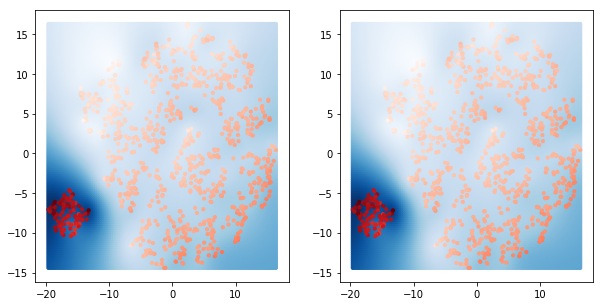

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].scatter(
    x_c, y_c, 
    s=10, alpha=1, c = z_c1, 
    cmap=plt.get_cmap('Blues'))

axes[0].scatter(
    x, y, 
    s=10, alpha=1, c = z, 
    cmap=plt.get_cmap('Reds'))

axes[1].scatter(
    x_c, y_c, 
    s=10, alpha=1, c = z_c2, 
    cmap=plt.get_cmap('Blues'))

axes[1].scatter(
    x, y, 
    s=10, alpha=1, c = z, 
    cmap=plt.get_cmap('Reds'))


#plt.colorbar()
plt.show()